In [8]:
import os
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import matplotlib.pyplot as plt

import fiona

In [6]:
#get band names
bandPath = './data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/'
bandNames = os.listdir(bandPath)
bandNames

['T18LUM_20200917T151709_B12.jp2',
 'T18LUM_20200917T151709_B11.jp2',
 'T18LUM_20200917T151709_B05.jp2',
 'T18LUM_20200917T151709_B02.jp2',
 'T18LUM_20200917T151709_TCI.jp2',
 'T18LUM_20200917T151709_B8A.jp2',
 'T18LUM_20200917T151709_B06.jp2',
 'T18LUM_20200917T151709_B07.jp2',
 'T18LUM_20200917T151709_B03.jp2',
 'T18LUM_20200917T151709_B10.jp2',
 'T18LUM_20200917T151709_B04.jp2',
 'T18LUM_20200917T151709_B09.jp2',
 'T18LUM_20200917T151709_B08.jp2',
 'T18LUM_20200917T151709_B01.jp2']

In [10]:
#import area of interest as Fiona geometry
aoiFile = fiona.open('./data/soilClassificationwithMachineLearningwithPythonScikitLearn/shp/AOI.shp')
aoiGeom = [aoiFile[0]['geometry']]

In [13]:
with open(os.path.join(bandPath, bandNames[0])) as f:
    print(f)

<_io.TextIOWrapper name='./data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/T18LUM_20200917T151709_B12.jp2' mode='r' encoding='UTF-8'>


In [15]:
with rasterio.open("./data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/T18LUM_20200917T151709_B01.jp2") as rasterBand:
    outImage, outTransform = mask(rasterBand, aoiGeom, crop=True)
    outMeta = rasterBand.meta
    outMeta.update({"driver": 'JP2OpenJPEG',
                    "height": outImage.shape[1],
                    "width": outImage.shape[2],
                    "transform": outTransform})
    outRaster = rasterio.open("./output/rst/test.jp2", "w", **outMeta) 
    outRaster.write(outImage)
    outRaster.close()

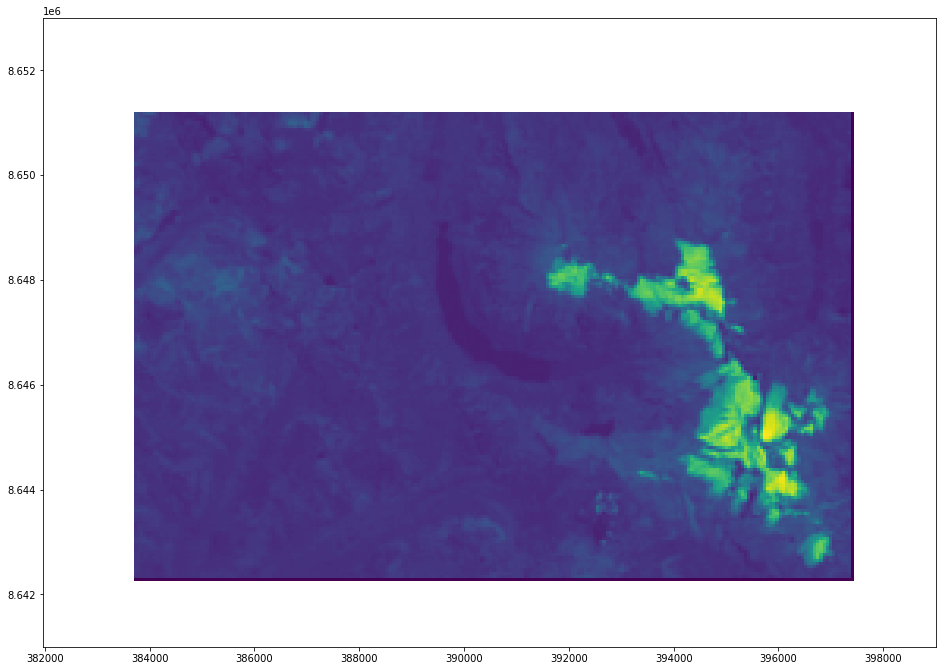

In [18]:
#plot original and clipped rasters
rasterBand = rasterio.open("./data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/T18LUM_20200917T151709_B01.jp2")
bandZero = rasterio.open("./output/rst/test.jp2",'r')
fig, ax = plt.subplots(figsize=(16,16))
#show(rasterBand, cmap='Blues', ax=ax)
show(bandZero, cmap='viridis', ax=ax)
ax.set_ylim(rasterBand.bounds.bottom,rasterBand.bounds.top)
ax.set_xlim(rasterBand.bounds.left,rasterBand.bounds.right)
plt.show()
bandZero.close()

In [84]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.windows import Window
import time
import zarr
import numpy as np

# inspired by https://gist.github.com/lucaswells/fd2fd73c513872966c1a0257afee1887
def convert(raster_filepath, zarr_filepath, chunk_mbs=1):
    """
    Converts raster file to chunked and compressed zarr array.

    Parameters
    ----------
    raster_filepath : string
        Path and filename of input raster
    chunk_mbs : float, optional
        Desired size (MB) of chunks in zarr file
    """

    # Open the raster file
    raster = rasterio.open(raster_filepath)

    # Extract metadata we need for initializing the zarr array
    width = raster.width
    height = raster.height
    n_bands = raster.count
    dtype = raster.dtypes[0].lower()

    # Specify the number of bytes for common raster
    # datatypes so we can compute chunk shape
    dtype_bytes = {
        'byte'     : 1.,
        'uint16'   : 2.,
        'int16'    : 2.,
        'uint32'   : 4.,
        'int32'    : 4.,
        'float32'  : 4.,
        'float64'  : 8.,
    }

    # Compute the chunk shape
    chunk_shape = (int((chunk_mbs * 1e6/dtype_bytes[dtype])**0.5),)*2 #TODO: chunk size is not the correct one in the end

    # Create zarr store
    store = zarr.DirectoryStore(zarr_filepath)

    xmin, ymin, xmax, ymax = raster.bounds

    x = zarr.create(
        shape=(width,),
        dtype='float32',
        store=store,
        overwrite=True,
        path="x"
    )
    x[:] = np.arange(xmin, xmax, (xmax-xmin)/width)
    x.attrs['_ARRAY_DIMENSIONS'] = ['x']

    y = zarr.create(
        shape=(height,),
        dtype='float32',
        store=store,
        overwrite=True,
        path="y"
    )
    y[:] = np.arange(ymin, ymax, (ymax-ymin)/height)
    y.attrs['_ARRAY_DIMENSIONS'] = ['y']

    for k in raster.indexes:
        # Create zarr array for each band required
        zarray = zarr.create(
            shape=(width, height),
            chunks=chunk_shape,
            dtype=dtype,
            store=store,
            overwrite=True,
            path=k #TODO: replace k with the name of the band
        )

        # Let's add the metadata to the zarr file
        zarray.attrs['width'] = width
        zarray.attrs['height'] = height
        zarray.attrs['count'] = n_bands
        zarray.attrs['dtype'] = dtype
        zarray.attrs['bounds'] = raster.bounds
        zarray.attrs['transform'] = raster.transform
        zarray.attrs['crs'] = raster.crs.to_string()
        zarray.attrs['_ARRAY_DIMENSIONS'] = ['x', 'y']

        # Now we'll read and write the data according to the chuck size to prevent memory saturation
        for xstart in range(0, width+chunk_shape[0], chunk_shape[0]):
            if xstart > width:
                continue
            xend = min(xstart + chunk_shape[0], width)
            for ystart in range(0, height+chunk_shape[1], chunk_shape[1]):
                if ystart > height:
                    continue
                yend = min(ystart + chunk_shape[1], height)

                print('Chunk')
                print(f'column {xstart} to {xend} out of {width}')
                print(f'line {ystart} to {yend} out of {height}\n')

                data = raster.read(k, window=Window(xstart, ystart, xend - xstart, yend - ystart))
                zarray[xstart:xend, ystart:yend] = np.transpose(data)
    
    # Close the raster dataset; no need to close the zarr file
    raster.close()

    # Consolidate the metadata into a single .zmetadata file
    zarr.consolidate_metadata(store)

In [66]:
JP2_FILE = "./data/soilClassificationwithMachineLearningwithPythonScikitLearn/S2B_MSIL1C_20200917T151709_N0209_R125_T18LUM_20200917T203629.SAFE/GRANULE/L1C_T18LUM_A018455_20200917T151745/IMG_DATA/T18LUM_20200917T151709_B01.jp2"
ZARR_FILE = "./output/zarr/test"
convert(JP2_FILE, ZARR_FILE, chunk_mbs=0.05)

158.11388300841898
('uint16',)
Chunk
column 0 to 158 out of 284
line 0 to 158 out of 200

Chunk
column 0 to 158 out of 284
line 158 to 200 out of 200

Chunk
column 158 to 284 out of 284
line 0 to 158 out of 200

Chunk
column 158 to 284 out of 284
line 158 to 200 out of 200



In [60]:
import xarray as xr

xr.open_zarr(ZARR_FILE)

<xarray.Dataset>
Dimensions:  (x: 284, y: 200)
Coordinates:
  * x        (x) float32 3.82e+05 3.82e+05 3.821e+05 ... 3.989e+05 3.989e+05
  * y        (y) float32 8.641e+06 8.641e+06 8.641e+06 ... 8.653e+06 8.653e+06
Data variables:
    1        (x, y) float32 dask.array<chunksize=(158, 158), meta=np.ndarray>

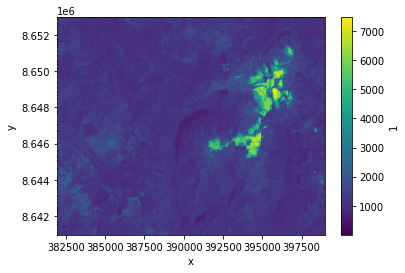

In [57]:
xr.open_zarr(ZARR_FILE).get("1").plot(x="x", y="y")